<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/seminar_13_kernel_density_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bandwidth and kenel influence on 1D KDE

In [0]:
# install KDEpy library before starting the following demo
!pip install KDEpy

In [0]:
#@title Bandwidth and kernel in KDE
from google.colab import widgets
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import LeaveOneOut #train_test_split
from KDEpy import FFTKDE


params = []
X = []
b_w = ipywidgets.FloatSlider(description='bandwidth', min=1, max=50.0, value=15.0)
ker_type = ipywidgets.Dropdown(
  options=['gaussian', 'tophat', 'epanechnikov', 'exponential','linear','cosine'],
  value='gaussian',
  description='Kernel:',
  disabled=False)

def set_slider(x):
  bandwidths = np.linspace(b_w.min, b_w.max, 100)
  loo = LeaveOneOut()
  grid = GridSearchCV(KernelDensity(kernel=ker_type.value), {'bandwidth': bandwidths}, cv=loo)
  grid.fit(np.array(X)[:, None]);
  b_w.value = grid.best_params_['bandwidth']

def set_slider2(x):
  ker = {'gaussian':'gaussian', 'cosine':'cosine', 
         'tophat':'box', 'epanechnikov':'epa', 
         'exponential':'exponential', 'linear':'tri'}
  kde = FFTKDE(bw='ISJ', kernel=ker[ker_type.value])
  kde.fit(X)(None)
  b_w.value = kde.bw

def set_slider1(x):
  #std = np.sqrt(np.var(X, axis=0))
  #silverman = ((4/(3* len(np.array(X)[:, None])))*std**5)**(1/5)
  #b_w.value = silverman

  ker = {'gaussian':'gaussian', 'cosine':'cosine', 
         'tophat':'box', 'epanechnikov':'epa', 
         'exponential':'exponential', 'linear':'tri'}
  kde = FFTKDE(bw='silverman', kernel=ker[ker_type.value])
  kde.fit(X)(None)
  b_w.value = kde.bw

def plot_pdf(plot_separate, k_d = None):
  global params
  global X
  if not params:
    return

  pi1, pi2, pi3, mu1, sig1, mu2, sig2, mu3, sig3 = params
  x = np.linspace(np.min(X), np.max(X), 1001)
  fig = plt.figure(figsize=(10, 8))
  P_sum = np.zeros(x.shape)
  for mu, sig, c, pi, i in [[mu1, sig1, 'r', pi1, 1], [mu2, sig2, 'g', pi2, 2], [mu3, sig3, 'b', pi3, 3]]:
    P = scipy.stats.norm.pdf(x, mu, sig)
    P_sum += P * pi
    if plot_separate:
      plt.plot(x, P, c, linewidth=2.0, label="{}".format(i), alpha=np.clip(pi, 0.0, 1.0))
  
  plt.plot(x, P_sum, 'k', linewidth=3.0, label="mixture")
  plt.plot(np.array(X), np.full_like(np.array(X), 0.0), '|k', markeredgewidth=1)
  plt.title('True pdf / pdf estimate')
  plt.xlabel('x')
  plt.ylabel('pdf')
  plt.legend()
  #plt.show()

def set_and_plot(pi, mu1, sig1, mu2, sig2, mu3, sig3):
  pi1, pi2 = pi; pi2 -= pi1; pi3 = 1.0 - pi2 - pi1;
  global params
  global X
  X = []
  params = [pi1, pi2, pi3, mu1, sig1, mu2, sig2, mu3, sig3]
  N = 200
  for mu, sig, pi in [[mu1, sig1, pi1], [mu2, sig2, pi2], [mu3, sig3, pi3]]:
    X = X + np.random.normal(mu, sig, int(N * pi)).tolist()
  plot_pdf(True)


def ker_plot(b_w, k_t):
  kde = KernelDensity(bandwidth=b_w, kernel=k_t)
  global X
  kde.fit(np.array(X)[:, None])
  x_d = np.linspace(np.min(X), np.max(X), 1001)
  logprob = kde.score_samples(x_d[:, None])
  plot_pdf(False)
  plt.fill_between(x_d, np.exp(logprob), alpha=0.5, color='r')

tb = widgets.TabBar(['mix distribution', 'find KDE'], location='top')
with tb.output_to(0):
  words = ['mu_1', 'sigma_1', 'mu_2', 'sigma_2', 'mu_3', 'sigma_3']
  mins  = [0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
  maxes = [100.0, 10.0, 100.0, 10.0, 100.0, 10.0]
  vals  = [10.0, 10.0, 50.0, 10.0, 90.0, 10.0]
  sliders = [ipywidgets.FloatSlider(description=w, min=n, max=x, value=v) for w,x,n,v in zip(words, maxes, mins, vals)]
  pi_slider = ipywidgets.FloatRangeSlider(value=[0.3, 0.6], min=0.0, max=1.0, description='pi(1,2,3)')
  boxes = [ipywidgets.VBox([pi_slider])]
  for slider1, slider2 in zip(sliders[::2], sliders[1::2]):
    boxes.append(ipywidgets.VBox([slider1, slider2]))
  out = ipywidgets.interactive_output(set_and_plot, {
    "pi": pi_slider,
    "mu1": sliders[0], "sig1": sliders[1],
    "mu2": sliders[2], "sig2": sliders[3],
    "mu3": sliders[4], "sig3": sliders[5]})
  display(ipywidgets.HBox(boxes), out)
with tb.output_to(1):
  btn = ipywidgets.Button(
    description='Cross Validation',
    disabled=False,
    button_style='')
  btn1 = ipywidgets.Button(
    description='Silverman',
    disabled=False,
    button_style='')
  btn2 = ipywidgets.Button(
    description='ISJ',
    disabled=False,
    button_style='')
  out = ipywidgets.interactive_output(ker_plot, {"b_w": b_w, "k_t": ker_type})
  display(ipywidgets.HBox([ker_type, ipywidgets.VBox([b_w, ipywidgets.HBox([btn1, btn2, btn])])]), out)
  btn.on_click(set_slider)
  btn1.on_click(set_slider1)
  btn2.on_click(set_slider2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

#KDE in 2D (kernel, bandwidth, sample, metric)

In [0]:
from sklearn.neighbors import KernelDensity
# instantiate and fit the KDE model
kde = KernelDensity()

def fit_distribution(X, bandwidth, ker_name, metric_name):
  params = {'bandwidth': bandwidth, 'kernel': ker_name, 'metric': metric_name}
  kde.set_params(**params)
  kde.fit(X)

def evaluate_distribution(X):
  logprob = kde.score_samples(X)
  return np.exp(logprob)

In [0]:
#@title Interactive 2D KDE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
        
def plot_clusters(x_, y_, z_):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  #ax = sns.kdeplot(X[:,0], X[:,1], cmap="Blues", shade=True, shade_lowest=False)
  sns.set()
  ax.contourf(x_, y_, z_, alpha=0.5, cmap="Blues")
  ax.tick_params(axis="y",direction="in", pad=-60)
  ax.tick_params(axis="x",direction="in", pad=-30)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  plt.close(fig)
  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64



import json
from IPython.display import display, clear_output

def invoke(pts, n, ker_name, metric_name):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0
  fit_distribution(X, float(n)/1000.0, ker_name, metric_name)
  x_ = np.linspace(-1.0, +1.0, num=300)
  y_ = np.linspace(-1.0, +1.0, num=300)
  xx, yy = np.meshgrid(x_, y_)
  x_vec = np.transpose(np.vstack([xx.ravel(), yy.ravel()]))
  G  = evaluate_distribution(x_vec).reshape((x_.shape[0],y_.shape[0]))
  figr = plot_clusters(x_, y_, G)
  image_base64 = figure_to_base64(figr)

  return IPython.display.JSON({'image': image_base64, 
                               'g_x': x_.tolist(), 'g_y': y_.tolist(), 'g_z': G.tolist(),
                               's_x': X[:, 0].tolist(), 's_y': X[:, 1].tolist(), 's_z': [0]*len(X)})


import IPython
from google.colab import output

main_str = '''
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(255, 128, 0, 0.5)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });

      }
    }
    
    var timer

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      evt.stopPropagation();
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }


   function plot_3d(g_x, g_y, g_z)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');
     //Plotly.deleteTraces(cell_for_plot, [0, 1]);
     var data = [{
           x: g_x,
           y: g_y,
           z: g_z,
           type: 'surface',
           opacity: 0.9,
           showscale: false,
           colorscale: "Viridis"
        }];
  
     var layout = {
          title: 'pdf estimate',
          autosize: false,
          width: 600,
          height: 600,
          showlegend: false,
          scene: {
            camera: {
              up: {x: 0, y: 1, z: 0},
              center: {x: 0, y: 0, z: 0},
              eye: {x: 0.0, y: -1.0, z: 1.4}
            }
          }
        };
     Plotly.newPlot(cell_for_plot, data, layout);
   }

   function plot_scatter(s_x, s_y, s_z)
   {
          
     cell_for_plot = document.getElementById('for_plotly_plot');
     var data = [{
           x: s_x,
           y: s_y,
           z: s_z,
           type: 'scatter3d',
           mode: 'markers',
           marker: {
             size: 4,
             colorscale: "Viridis",
             line: {
               width: 2,
               color: 'rgba(0, 0, 0, 0.5)'
             }
           }
        }];
    Plotly.plot(cell_for_plot, data, {});
   }


    var cur_depth = 100;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      var e = document.getElementById("select_kernel");
      var ker_name = e.options[e.selectedIndex].value;
      var e1 = document.getElementById("select_metric");
      var metric_name = e1.options[e1.selectedIndex].value;
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged, cur_depth, ker_name, metric_name], {});
      params = result.data['application/json'];
            
      bg_image.src = 'data:image/  png;base64,' + params.image;
      cell_for_plot = document.getElementById('for_plotly_plot');
      
      plot_3d(params.g_x, params.g_y, params.g_z);
      plot_scatter(params.s_x, params.s_y, params.s_z);
      
    }

   function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x;
    el.innerHTML = x;
  }

 </script>

<div id="everything" style="height:600px;">
<div id="for_plotly_plot" style="position:absolute; top:0px; left:0px; height:600px; width:600px;">
</div>
<div id="custom_controls" style="position:absolute; top:0px; left:600px;">
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add Feature
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move Features
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete Feature
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>Bandwidth x 1000:<br>
    <input type="range" min="1" max="200" value="100" oninput="h_change(this.value)">
    <br><div id="slider_val">100</div>
   <br>Kernel:<br>
   <select id="select_kernel">
       <option value="gaussian">gaussian</option>
       <option value="tophat">tophat</option>
       <option value="epanechnikov">epanechnikov</option>
       <option value="exponential">exponential</option>
       <option value="linear">linear</option>
       <option value="cosine">cosine</option>
   </select>
   <br>
   Metric:
   <br>
   <select id="select_metric">
       <option value="euclidean">euclidean</option>
       <option value="l2">l2</option>
       <option value="minkowski">minkowski</option>
       <option value="p">p</option>
       <option value="manhattan">manhattan</option>
       <option value="cityblock">cityblock</option>
       <option value="l1">l1</option>
       <option value="chebyshev">chebyshev</option>
       <option value="infinity">infinity</option>
   </select>
   <br><br>
    <button type="button" onclick="calculate();">
      KDE
    </button>
  </div>
</div>
<div>
  
<script>
function init()
{
  timer = setInterval(draw, 10);
}

init();
</script>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.InvSVM', invoke)

#Cholera outbreak visualization


![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/snows.png) 


![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/mapsnow.png) 

**Preparation**

Download the dataset in a `csv` format from github.
Following code should do the job.

In [81]:
# download the dataset
!wget https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/pumps.csv
!wget https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/deaths.csv
!wget https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/cholera_map.jpg

--2019-12-07 16:09:02--  https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/pumps.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118 [text/plain]
Saving to: ‘pumps.csv’

pumps.csv           100%[===================>]     118  --.-KB/s    in 0s      

2019-12-07 16:09:02 (22.4 MB/s) - ‘pumps.csv’ saved [118/118]

--2019-12-07 16:09:04--  https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/deaths.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4811 (4.7K) [text/plain]
Saving to: ‘d

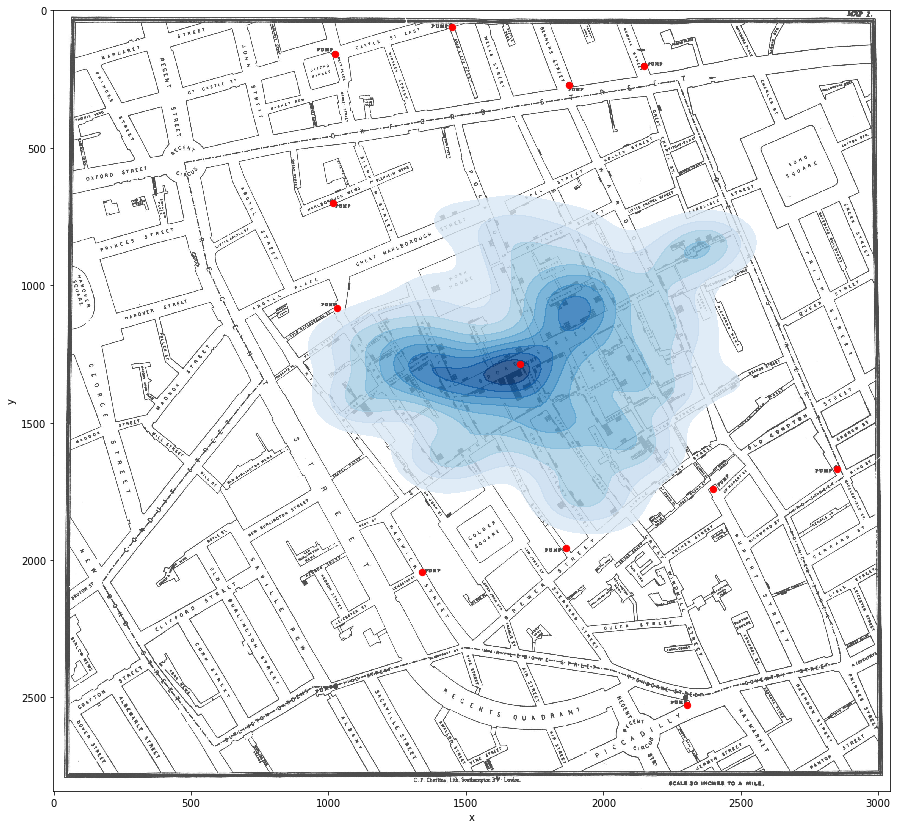

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pumps = pd.read_csv('pumps.csv')
deaths = pd.read_csv('deaths.csv')
cholera_map = plt.imread('cholera_map.jpg')

fig = plt.figure(figsize=(15, 15));
plt.imshow(cholera_map, alpha=0.7);
#plt.scatter(x=deaths['x'], y=deaths['y'], c='b', s=40);
sns.kdeplot(deaths['x'], deaths['y'], cmap="Blues", shade=True, shade_lowest=False, alpha=0.8);
plt.scatter(x=pumps['x'], y=pumps['y'], c='r', s=40);